# Hyperparameters for RF

In [1]:
%load_ext autoreload
%autoreload 2

# 1. Importing Libraries 

In [2]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline



import os, sys, pickle, copy, joblib

from pathlib import Path
import pandas as pd
import numpy as np
from time import sleep
from tqdm import tqdm, tqdm_notebook
import AFQ_utils as utils
from matplotlib import pyplot as plt

import seaborn as sns; sns.set()
sns.set_theme(style="white")

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer , r2_score, mean_absolute_error, explained_variance_score, \
mean_absolute_percentage_error, mean_squared_error, max_error, median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector


# for windows
#from sklearnex import patch_sklearn
#patch_sklearn()

define constants and dcitionaries to easy looping

In [3]:
# constanst
crs_to='epsg:4326'
crs_from='epsg:4326'
projection = 'M5.4i'
#parent directory

DIR = Path().resolve() 


# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

region_afr = [afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max]
region_world = [world_lon_min, world_lon_max, world_lat_min, world_lat_max]



In [4]:
obs = pd.DataFrame()


obs["OBS_REF"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV","PV", 
            "GEOID","FA","DEM","BG", "EMAG2_CLASS",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST_W", "REG", "GLIM"]

obs["OBS_AFR"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV_SPEED","PV_SPEED", 
            "GEOID","FA","DEM","BG", "EMAG2",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST", "REG", "GLIM"]
  
     
# Labels for plots etc


# Labels for plots etc
obs["LABELS_gmt"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "S@_v@ 150km", "P@_v@ 150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. rho", "Crust rho",  
                 "Volcano", "REG", "GliM", ]  


obs["LABELS"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "$S_v$ @150km", "$P_v$ @150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. ρ", "Crust ρ",  
                 "Volcano", "REG", "GliM", ]
    
# "vp/vs"
# Units to display in plots etc
obs["UNITS"] = ["km",  "si", "km", "km",
             "$\delta$$S_v$ %","$\delta$$P_v$ %", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m$^3$", "kg/m$^3$",
                "km",  "class", "class"]



obs["UNITS_gmt"] = ["km",  "si", "km", "km",
             "km/s","km/s", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m@+3@+", "kg/m@+3@+",
                "km",  "class", "class"]
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs["V_RANGE"] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,16),]


    
obs["V_RANGE_AFR"] = [(0,50), (-1,1),(50,250),(20,50),
          (-0.075,0.075), (-0.02,0.02), 
          (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-200, 200), 
               (3260, 3360), (2650, 2950),
              (0,100), (1,6),(1,15),]


obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","categorical", ]

obs["CMAPS"] = ["SCM/bamako",  "SCM/broc", "SCM/bamako", "SCM/bamako", 
             "SCM/roma","SCM/roma", 
             "SCM/bamako", "SCM/broc", "SCM/oleron", "SCM/broc", "SCM/bilbao",            
                "SCM/batlow", "SCM/batlow",
               "SCM/broc",  "gmt/categorical","gmt/categorical", ]

new_index = [0,1,2,3,4,5,6,8,7,9,10,11,12,13,14,15]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

obs = obs.reindex(new_index)

#obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 16




obs_dict = obs.to_dict(orient='records')

obs.set_index(['OBS_REF'], inplace=True)



obs

OBS_AFR   LABELS_gmt        LABELS            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR            CMAPS
OBS_REF                                                                                                                         
CTD                CTD          CTD           CTD               km         km          (0, 50)          (0, 50)       SCM/bamako
SI                  SI  Shape index   Shape index               si         si          (-1, 1)          (-1, 1)         SCM/broc
LAB                LAB          LAB           LAB               km         km         (0, 300)        (50, 250)       SCM/bamako
MOHO              MOHO         Moho          Moho               km         km         (15, 60)         (20, 50)       SCM/bamako
SV            SV_SPEED  S@_v@ 150km  $S_v$ @150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)         SCM/roma
PV            PV_SPEED  P@_v@ 150km  $P_v$ @150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)         SCM/roma
GEOID            GEOID        Geoid         Geoid                m          m        (-45, 45)        (-45, 45)       SCM/bamako
DEM                DEM          DEM           DEM                m          m    (-2200, 2200)    (-2200, 2200)       SCM/oleron
FA                  FA     Free air      Free air             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
BG                  BG      Bouguer       Bouguer             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
EMAG2_CLASS      EMAG2         Mag.          Mag.            f(nT)      f(nT)      (-0.4, 0.4)      (-200, 200)       SCM/bilbao
RHO_L            RHO_L    Lith. rho       Lith. ρ         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)       SCM/batlow
RHO_C            RHO_C    Crust rho       Crust ρ         kg/m$^3$  kg/m@+3@+     (2650, 2950)     (2650, 2950)       SCM/batlow
VOLC_DIST_W  VOLC_DIST      Volcano       Volcano               km         km           (0, 1)         (0, 100)         SCM/broc
REG                REG          REG           REG            class      class           (1, 6)           (1, 6)  gmt/categorical
GLIM              GLIM         GliM          GliM            class      class          (1, 16)          (1, 15)  gmt/categorical

In [5]:

target = 'GHF'
coord = ['lon', 'lat']
grid_index_world = 'grid_index_world'
grid_index_afr = 'grid_index_afr'

#######

features_ex = []
features_ghf = []



features = obs.index.to_list()



in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.append(grid_index_world)
features_ex.append(grid_index_afr)

features_ex.append(target)

features_ghf = copy.deepcopy(features)
features_ghf.append(target)


features_ex

['CTD',
 'SI',
 'LAB',
 'MOHO',
 'SV',
 'PV',
 'GEOID',
 'DEM',
 'FA',
 'BG',
 'EMAG2_CLASS',
 'RHO_L',
 'RHO_C',
 'VOLC_DIST_W',
 'REG',
 'GLIM',
 'lon',
 'lat',
 'grid_index_world',
 'grid_index_afr',
 'GHF']

In [6]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    
    y_true = y_true.ravel().reshape(-1,)
    y_pred = y_pred.ravel().reshape(-1,)
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

def accuracy(y_true, y_pred):
    cost  = mean_absolute_percentage_error(y_true, y_pred)
    return (100 - (cost * 100)) 

def min_e(y_true, y_pred):
    cost  = abs(y_true - y_pred)
    return cost.min()

def mpe(y_true, y_pred):
    return np.mean((y_true -y_pred)/y_true) 



scores_cv = {

'RMSE'     :  make_scorer(mean_squared_error , squared=False),
'NRMSE'    :  make_scorer(nrmse),
'MAE'      :  make_scorer(mean_absolute_error),    
'MAPE'     :  make_scorer(mean_absolute_percentage_error ),
'ACC'      :  make_scorer(accuracy) ,
'MPE'      :  make_scorer(mpe),
'CD'       :  make_scorer(r2_score),
'EV'       :  make_scorer(explained_variance_score),
'MAX_E'    :  make_scorer( max_error),
'MIN_E'    :  make_scorer(min_e),
'MedAE'    :  make_scorer(median_absolute_error),
'CCC'      :  make_scorer(concordance_correlation_coefficient),
    
}

# 3. Hyperparameters tuning

In [118]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV

kfold = 5
n_iter = 100
random_state = 42

#grid_search_dict = { }

train_df = pd.read_csv(DIR /'Dataset'/'Preprocessed'/f'W_OD_rab.csv', sep='\t')

X = train_df[features]
y = train_df[target] 

X['GLIM']  = X['GLIM'].astype('int').astype('category')
X['REG']   = X['REG'].astype('int').astype('category')



#scoring = make_scorer(nrmse , greater_is_better=False )
scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
cv = KFold(n_splits=kfold, random_state=random_state, shuffle=True)

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

# param distribution
n_estimators      =  np.arange(100, 600,50) # overfits
max_depth         =  list(range(5,60,3)); max_depth.append(None); # overfits
max_features      =  list(range(1, X.shape[1]))  # overfits 
#min_samples_leaf  =  np.linspace(1, 0.5*X.shape[0], 10)# underfits
min_samples_leaf  =  list(range(1, int(0.1*X.shape[0]), 1))# underfits
min_samples_split =  np.linspace(2, X.shape[0], 500, dtype='int') # underfits





# Update dict with Extra Trees
search_space = { 
        'regressor__n_estimators'     : n_estimators, 
         'regressor__max_depth'        : max_depth, 
         'regressor__max_features'     : max_features,  
         'regressor__min_samples_leaf' : min_samples_leaf,  
         'regressor__min_samples_split': min_samples_split,  
}

 #Create train and test set  

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)

for key, seach_value in search_space.items():
    regressor = RandomForestRegressor( )



    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ], 
        #remainder='passthrough', verbose_feature_names_out=False
    )


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]

    # Initialize Pipeline object
    pipeline_gs = Pipeline(steps = steps)
    #grid_reg_gs = GridSearchCV(pipeline_gs, param_grid = {key: seach_value}, scoring = scoring, cv=cv, verbose=2, n_jobs=3)
    #grid_reg_gs.fit(X, y)
    #grid_search_dict[key] = grid_reg_gs
    
    grid_reg_gs = RandomizedSearchCV(pipeline_gs, param_grid = {key: seach_value}, 
                                     scoring = scoring, cv=cv, verbose=2, n_jobs=3)
    #grid_reg_gs.fit(X, y)
    #grid_search_dict[key] = grid_reg_gs

    # Grid Search CV implementation
    '''halving_cv = HalvingGridSearchCV(pipeline_gs, param_grid = {key: seach_value},
                                     scoring = scoring, cv=cv, verbose=1, n_jobs=1)'''

    #halving_cv = HalvingRandomSearchCV(pipeline_gs, search_space,
    #                                 scoring = scoring, cv=cv, verbose=1, n_jobs=1)
    halving_cv.fit(X, y)
    #grid_search_dict[key] = halving_cv


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 10
max_resources_: 11781
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1178
n_resources: 10
Fitting 5 folds for each of 1178 candidates, totalling 5890 fits
----------
iter: 1
n_candidates: 393
n_resources: 30
Fitting 5 folds for each of 393 candidates, totalling 1965 fits
----------
iter: 2
n_candidates: 131
n_resources: 90
Fitting 5 folds for each of 131 candidates, totalling 655 fits
----------
iter: 3
n_candidates: 44
n_resources: 270
Fitting 5 folds for each of 44 candidates, totalling 220 fits
----------
iter: 4
n_candidates: 15
n_resources: 810
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 5
n_candidates: 5
n_resources: 2430
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 6
n_candidates: 2
n_resources: 7290
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingRandomSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                      estimator=Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  PowerTransformer(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015AE38225B0>),
                                                                                 ('cat',
                                                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                 unknown_value=-1),
                                                                                  <sklearn.compose....
       11049, 11072, 11096, 11120, 11143, 11167, 11190, 11214, 11238,
       11261, 11285, 11308, 11332, 11356, 11379, 11403, 11426, 11450,
       11474, 11497, 11521, 11544, 11568, 11592, 11615, 11639, 11662,
       11686, 11710, 11733, 11757, 11781]),
                                           'regressor__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550])},
                      scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
                      verbose=1)

In [25]:
 grid_search_dict['regressor__n_estimators'].cv_results_['mean_train_score']
    

array([ -9.54598527,  -9.55819455,  -9.53672071,  -9.5211451 ,
        -9.50876842,  -9.50865574,  -9.52454311,  -9.48188505,
        -9.50536829,  -9.47755375,  -9.47316021,  -9.47705193,
        -9.45192177,  -9.45797074,  -9.46060397,  -9.4635415 ,
        -9.46428938,  -9.48274323, -10.49142214, -10.48674015,
       -10.50006281, -10.49215219, -10.48865335, -10.49054529,
       -11.73498944, -11.74461251])

In [28]:
for key, grid in grid_search_dict.items():
    utils.plot_grid_search(grid, catgeories=[False])

In [76]:
np.unique(pd.DataFrame.from_dict(grid.cv_results_)['iter'].values)

array([0, 1, 2, 3, 4, 5, 6])

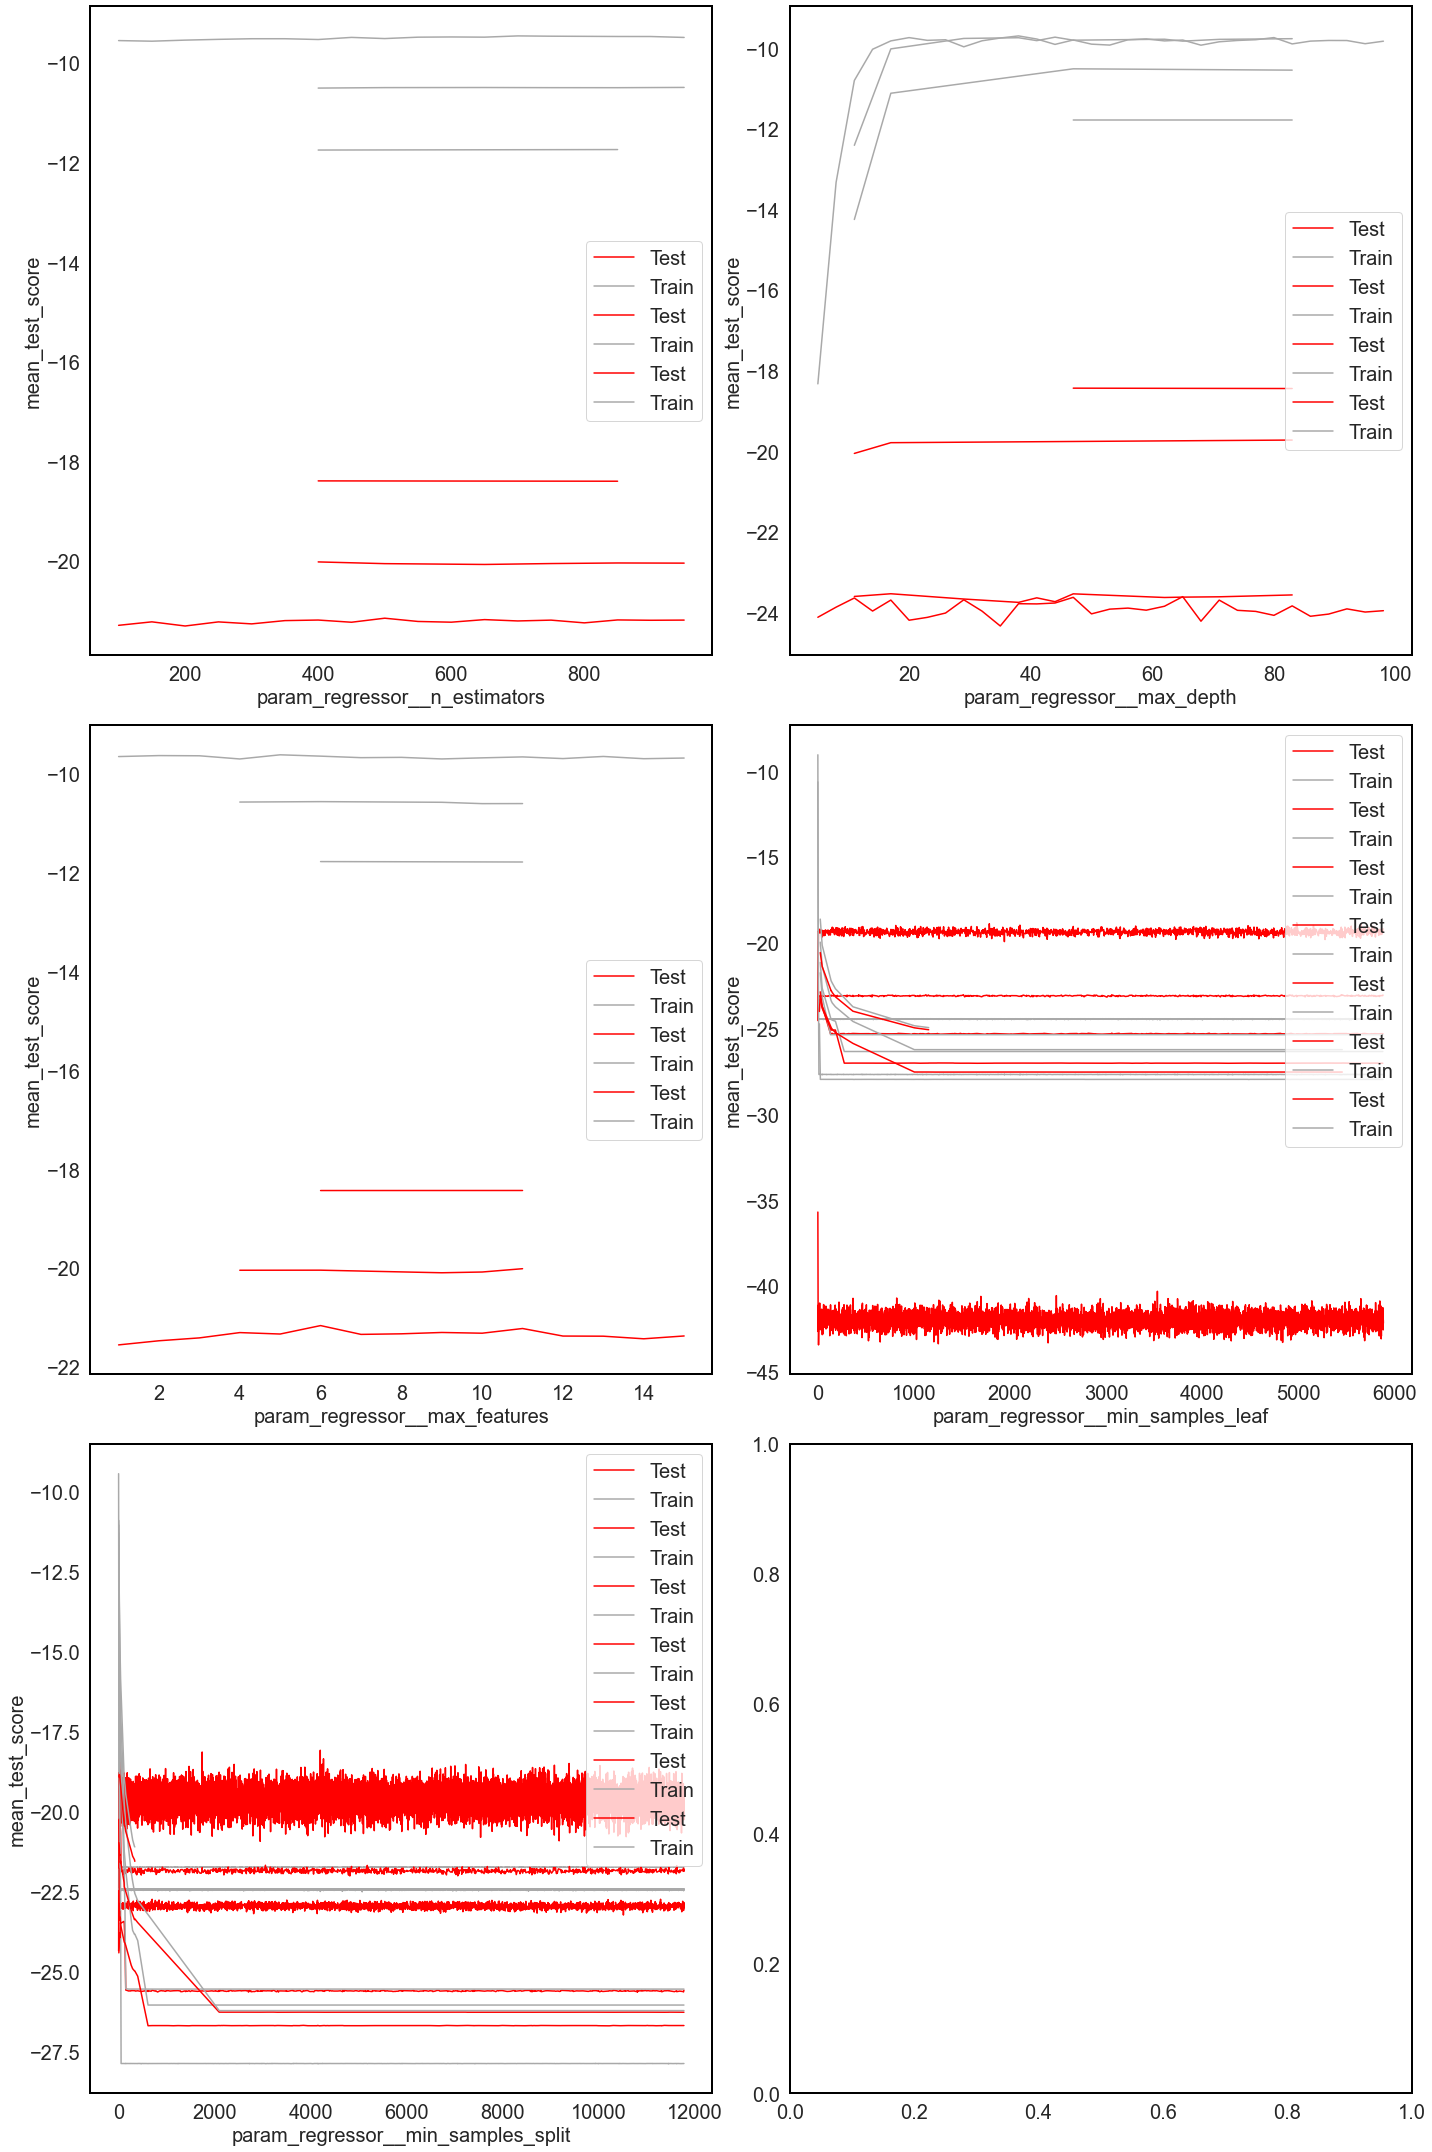

In [78]:
fig, axs = plt.subplots(ncols=2, nrows=3)

plt_params = {
    'legend.fontsize': 20,
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 2, 
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    "axes.labelsize" : 20,
}


plt.rcParams.update(plt_params)

#sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(20,30)

axs = axs.ravel()
i = 0

for key, grid in grid_search_dict.items():
    for iter_ in np.unique(pd.DataFrame.from_dict(grid.cv_results_)['iter'].values):
        sns.lineplot(f'param_{key}', 'mean_test_score' , 
                     data=pd.DataFrame.from_dict(grid.cv_results_)[pd.DataFrame.from_dict(grid.cv_results_)['iter']==iter_], 
                     ax=axs[i] ,  color='red', label ='Test',)
        sns.lineplot(f'param_{key}', 'mean_train_score' , 
                     data=pd.DataFrame.from_dict(grid.cv_results_)[pd.DataFrame.from_dict(grid.cv_results_)['iter']==iter_] , 
                     ax=axs[i] , color='darkgrey', label ='Train',)
    i+=1
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout()

plt.show()

KeyboardInterrupt: 

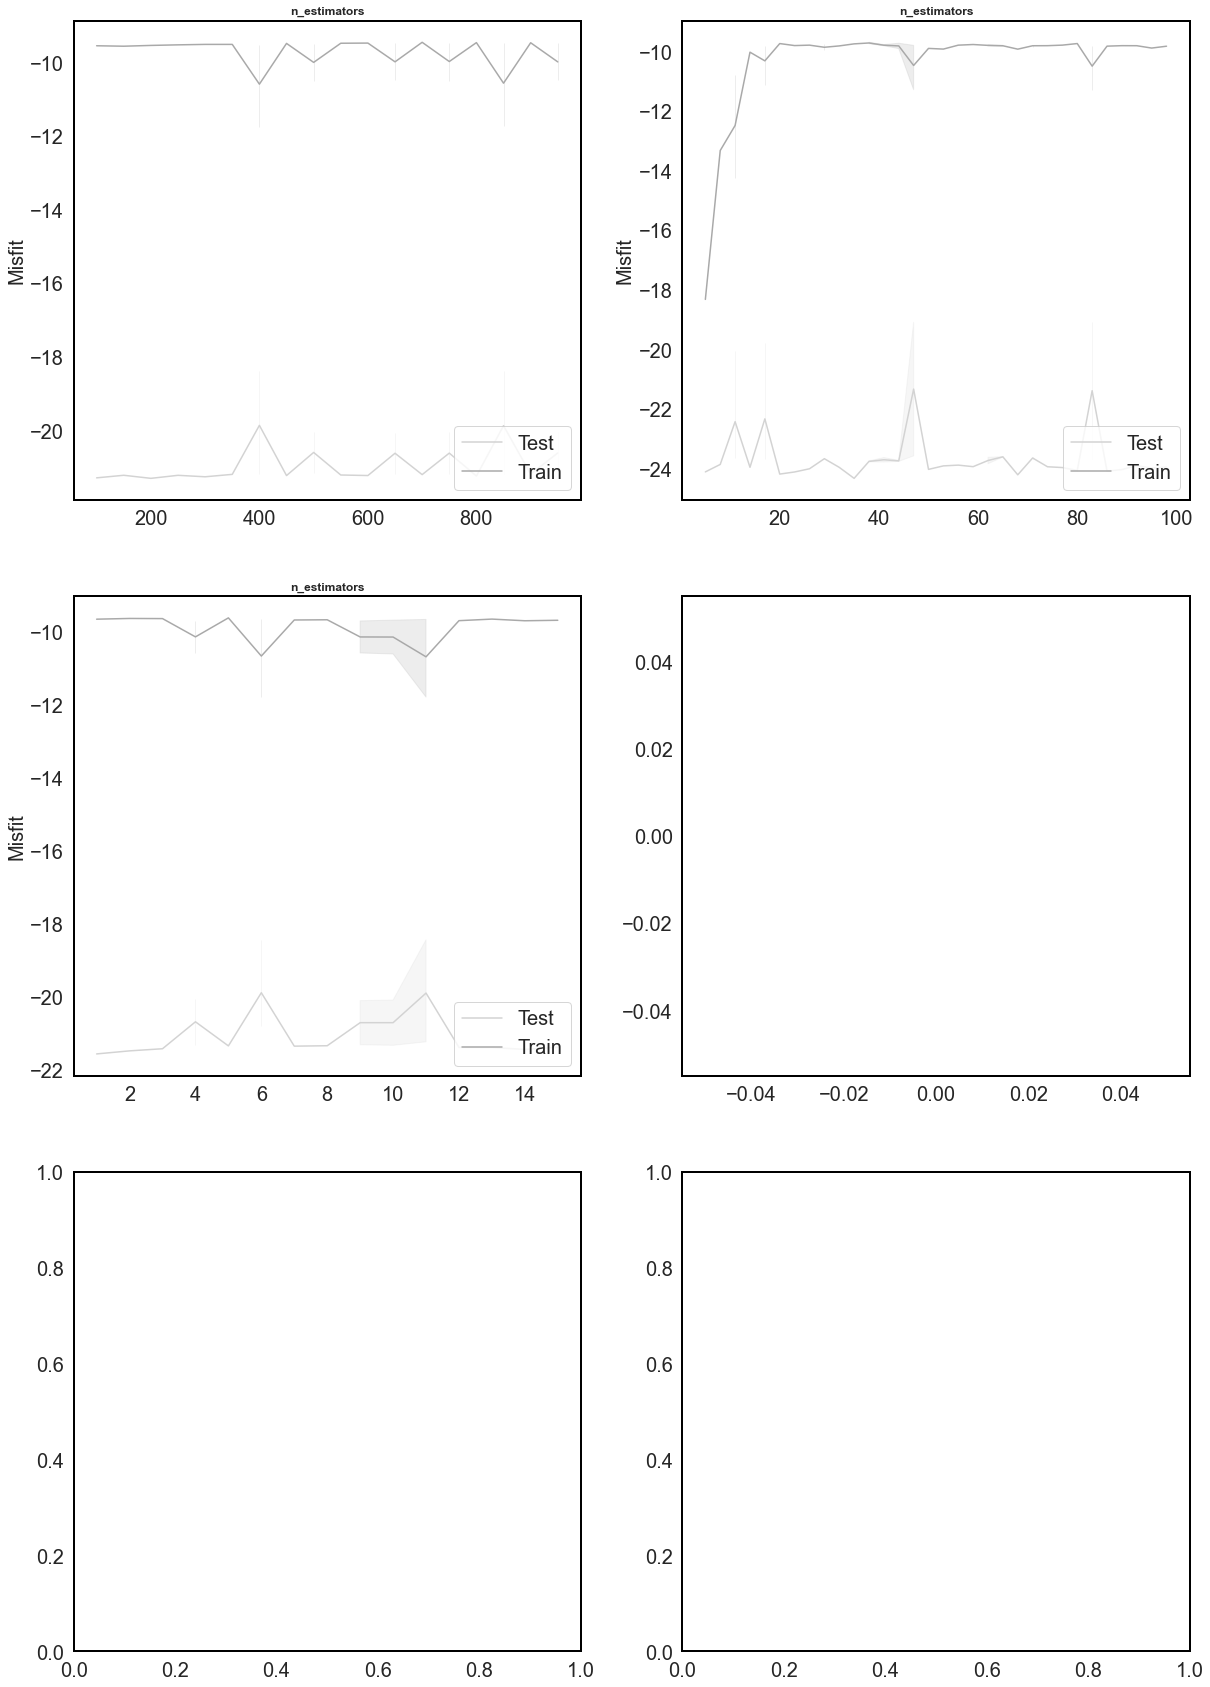

In [56]:


lower_bound, upper_bound = 0.2, 0.8

fig, axs = plt.subplots(ncols=2, nrows=3)

plt_params = {
    'legend.fontsize': 20,
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 2, 
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    "axes.labelsize" : 20,
}


plt.rcParams.update(plt_params)

#sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(20,30)

axs = axs.ravel()
i = 0
for key, grid in grid_search_dict.items():

    sns.lineplot(f'param_{key}', 'mean_test_score' , data=pd.DataFrame.from_dict(grid.cv_results_) , ax=axs[i] ,  color='lightgrey', label ='Test',)
    sns.lineplot(f'param_{key}', 'mean_train_score' , data=pd.DataFrame.from_dict(grid.cv_results_) , ax=axs[i] , color='darkgrey', label ='Train',)
    #axs[0,0].set(ylim=(lower_bound, upper_bound))
    axs[i].set_title(label = f'{parameter_1[17:]}', weight='bold')
    axs[i].legend(loc='lower right')
    axs[i].set_ylabel('Misfit')
    axs[i].set_xlabel('')
    i+=1


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout()

plt.show()


In [117]:
best_params = {}
for key, grid in grid_search_dict.items():
    best_params.update(grid.best_params_)
    
for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):
    
    regressor = RandomForestRegressor()



    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ], 
        #remainder='passthrough', verbose_feature_names_out=False
    )


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]
    model_pipeline = Pipeline(steps = steps)


    score  = np.mean(cross_validate(
                model_pipeline, 
                X, 
                y,
                 n_jobs=3,
                scoring=scoring,
                  cv=cv)['test_score'])
    print(f'{key} Deafult : {score:.2f} \n')

    model_pipeline.set_params(**best_params)

    score  = np.mean(cross_validate(
                model_pipeline, 
                X, 
                y,
                n_jobs=3,
                scoring=scoring,
                  cv=cv)['test_score'])
    print(f'{key} tuned  : {score:.2f} \n')


Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

RMSE Deafult : 18.51 

RMSE tuned  : 19.64 

NRMSE Deafult : 0.29 

NRMSE tuned  : 0.31 

MAE Deafult : 12.30 

MAE tuned  : 13.79 

MAPE Deafult : 0.25 

MAPE tuned  : 0.29 



KeyboardInterrupt: 

In [ ]:

for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):
    
    regressor = RandomForestRegressor()



    #numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

    preprocessor = ColumnTransformer(
        transformers=[
       #("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ], remainder='passthrough', verbose_feature_names_out=False
    )


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]
    model_pipeline = Pipeline(steps = steps)
    
       
    score  = np.mean(cross_validate(
                model_pipeline, 
                X, 
                y,
                 n_jobs=3
                scoring=scoring,
                  cv=cv)['test_score'])
    print(f'{key} Deafult : {score:.2f} \n')
    
    model_pipeline.set_params(**best_params)

    score  = np.mean(cross_validate(
                model_pipeline, 
                X, 
                y,
                n_jobs=3
                scoring=scoring,
                  cv=cv)['test_score'])
    print(f'{key} tuned  : {score:.2f} \n')
    
print('terminated')

In [ ]:

kfold = 5
n_iter = 100
random_state = 42


train_df = pd.read_csv(DIR /'Dataset'/'Preprocessed'/f'W_OD_rab.csv', sep='\t')

X = train_df[features]
y = train_df[target] 

X['GLIM']  = X['GLIM'].astype('int').astype('category')
X['REG']   = X['REG'].astype('int').astype('category')



#scoring = make_scorer(nrmse , greater_is_better=False )
scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
cv = KFold(n_splits=kfold, random_state=random_state, shuffle=True)

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

# param distribution
n_estimators      =  np.arange(100, 1000,50) # overfits
max_features      =  list(range(1, X.shape[1]))  # overfits
max_depth         =  list(range(5,100)); max_depth.append(None); # overfits
min_samples_split =  list(range(1, X.shape[0], 1)) # underfits
min_samples_leaf  =  list(range(1, int(0.5* X.shape[0]), 1)) # underfits





# Update dict with Extra Trees
search_space = { 
         'regressor__n_estimators'     : n_estimators, 
         'regressor__max_depth'        : max_depth, 
         'regressor__max_features'     : max_features,  
         'regressor__min_samples_leaf' : min_samples_leaf,  
         'regressor__min_samples_split': min_samples_split,  
}

 #Create train and test set  

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)


regressor = RandomForestRegressor()



#numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

preprocessor = ColumnTransformer(
    transformers=[
   #("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ], remainder='passthrough', verbose_feature_names_out=False
)


# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("regressor", regressor)]

# Initialize Pipeline object
pipeline_bscv = Pipeline(steps = steps)


# Initialize BaysSearch object                  
bscv = BayesSearchCV(
    pipeline_bscv,
    # (parameter space, # of evaluations)
    search_space,
    n_iter = n_iter, 
    cv = cv, 
    verbose = 3, 
    n_jobs= 2, 
    scoring= scoring,
    return_train_score=True,
    #refit=False,
    random_state=random_state
)



# Print message to user
print('#'*60)
print(f"Now tuning.")

# Fit gscv
bscv.fit(X, y)  

# Get best parameters and score
best_params = bscv.best_params_
best_score = bscv.best_score_

best_parms_df = pd.DataFrame(best_params,  index=[0])

# save best results and model
#best_parms_df.to_csv(DIR /'Hyperparameters'/f'BS_hyperparameter.csv' , index=False, sep='\t')

#joblib.dump(bscv, DIR /'Hyperparameters'/f'BSCV_model.pkl')



print('Optimization has terminated')



dropped_columns = ['mean_fit_time', 'std_fit_time',  'params', 'mean_score_time', 'std_score_time']

# all hyp results
# gives traing and validation results
bs_grid_df = pd.DataFrame(bscv.cv_results_)

bs_grid_df = bs_grid_df.sort_values(f'rank_test_score', ascending=True).reset_index(drop=True).copy(deep=True)

bs_grid_df['mean_test_score'] = bs_grid_df['mean_test_score'] *-1
bs_grid_df['mean_train_score'] = bs_grid_df['mean_train_score'] *-1

split_test = [f'split{x}_test_score' for x in range(kfold)]
split_train = [f'split{x}_train_score' for x in range(kfold)]

dropped_columns.extend(split_test)
dropped_columns.extend(split_train)


#save results

bs_grid_df.to_csv(DIR/'Hyperparameters'/f'BSCV_grid.csv' , index=False, sep='\t')





In [ ]:
#baseline


train_df = pd.read_csv(DIR /'Dataset'/'Preprocessed'/f'W_OD_rab.csv', sep='\t')


X = train_df[features]
y = train_df[target] 

X['GLIM']  = X['GLIM'].astype('int').astype('category')
X['REG']   = X['REG'].astype('int').astype('category')


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)


for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):
       
    score  = np.mean(cross_validate(
                model_pipeline, 
                X, 
                y,
                scoring=scoring,
                  cv=cv)['test_score'])
    print(f'{key}  : {score:.2f} \n')

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(model_pipeline['regressor'].get_params())

In [ ]:


#save results

bs_grid_df.to_csv(DIR/'Hyperparameters'/f'BSCV_grid.csv' , index=False, sep='\t')


# Print message to user
print('#'*60)
print(f"Now training .")

model_pipeline = Pipeline(steps = steps)
model_pipeline.set_params(**best_params)

for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):
       
    score  = np.mean(cross_validate(
                model_pipeline, 
                X, 
                y,
                scoring=scoring,
                  cv=cv)['test_score'])
    print(f'{key}  : {score:.2f} \n')




# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(model_pipeline['regressor'].get_params())



# save best results and model
#best_parms_df.to_csv(DIR /'Hyperparameters'/f'BS_hyperparameter.csv' , index=False, sep='\t')

#joblib.dump(bscv, DIR /'Hyperparameters'/f'BSCV_model.pkl')

# 4. Hyperparameters visualization

In [ ]:
parameter_1 = 'param_regressor__n_estimators'
parameter_2 = 'param_regressor__max_depth'
parameter_3 = 'param_regressor__max_features'
parameter_4 = 'param_regressor__min_samples_leaf'
parameter_5 = 'param_regressor__min_samples_split'


bs_df = pd.read_csv(DIR/'Hyperparameters'/f'BSCV_grid.csv')

lower_bound, upper_bound = 0.2, 0.8

fig, axs = plt.subplots(ncols=2, nrows=3)

plt_params = {
    'legend.fontsize': 20,
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 2, 
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    "axes.labelsize" : 20,
}


plt.rcParams.update(plt_params)

#sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(20,30)



sns.lineplot(parameter_1, 'mean_test_score' , data=bs_df, ax=axs[0,0] ,  color='lightgrey', label ='Test',)
sns.lineplot(parameter_1, 'mean_train_score' , data=bs_df, ax=axs[0,0] , color='darkgrey', label ='Train',)
#axs[0,0].set(ylim=(lower_bound, upper_bound))
axs[0,0].set_title(label = f'{parameter_1[17:]}', weight='bold')
axs[0,0].legend(loc='lower right')
axs[0,0].set_ylabel('Misfit')
axs[0,0].set_xlabel('')


####

sns.lineplot(x=parameter_2, y='mean_test_score', data=bs_df, ax=axs[0,1], color='lightpink', label ='Test',)
sns.lineplot(x=parameter_2, y='mean_train_score', data=bs_df, ax=axs[0,1], color='red' , label ='Train',)
#axs[0,1].set(ylim=(lower_bound, upper_bound))
axs[0,1].set_title(label = f'{parameter_2[17:]}', weight='bold')
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('')
#axs[0,1].locator_params(axis='x', nbins=len(bs_df)/6)
axs[0,1].set(yticklabels=[])  

axs[0,1].legend(loc='lower right')

######


sns.lineplot(x=parameter_3, y='mean_test_score', data=bs_df, ax=axs[1,0], color='yellow', label ='Test',)
sns.lineplot(x=parameter_3, y='mean_train_score', data=bs_df, ax=axs[1,0], color='orange' , label ='Train',)
#axs[0,1].set(ylim=(lower_bound, upper_bound))
axs[1,0].set_title(label = f'{parameter_3[17:]}', weight='bold')
#axs[1,0].locator_params(axis='x', nbins=len(bs_df)/6)
axs[1,0].set_ylabel('Misfit')
axs[1,0].legend(loc='lower right')


#########

sns.lineplot(x=parameter_4, y='mean_test_score', data=bs_df, ax=axs[1,1], 
             label ='Test', color='lightgreen')
sns.lineplot(x=parameter_4, y='mean_train_score', data=bs_df, ax=axs[1,1],
             label='Train', color='green')
#axs[1,1].set(ylim=(lower_bound, upper_bound))
axs[1,1].set_title(label = f'{parameter_4[17:]}', weight='bold')
axs[1,1].legend(loc='lower right')
axs[1,1].set(yticklabels=[])  
axs[1,1].set_ylabel('')
#axs[1,1].locator_params(axis='x', nbins=len(bs_df)/4)  # set divisor 
axs[1,1].set_xlabel('')

####

sns.lineplot(x=parameter_5, y='mean_test_score', data=bs_df, ax=axs[2,0], color='coral', label ='Test')
#axs[2,0].set(ylim=(lower_bound, upper_bound))
sns.lineplot(x=parameter_5, y='mean_train_score', data=bs_df, ax=axs[2,0], color='red', label='Train')
axs[2,0].set_title(label = f'{parameter_5[17:]}', weight='bold')
#axs[1,1].tick_params(labelsize=40) 
#axs[2,0].locator_params(axis='x', nbins=len(bs_df)/6)  # set divisor 

axs[2,0].legend(loc='lower right')
axs[2,0].set_ylabel('Misfit')
axs[2,0].set_xlabel('')
###


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout()

plt.show()

In [ ]:
categories = [False, False, False, False, False, False, ]

parameter_1 = 'param_regressor__n_estimators'
parameter_2 = 'param_regressor__max_depth'
parameter_3 = 'param_regressor__max_features'
parameter_4 = 'param_regressor__min_samples_leaf'
parameter_5 = 'param_regressor__min_samples_split'




    
bscv_i =  DIR/'Hyperparameters'/f'BSCV_model.pkl'

bscv = joblib.load(bscv_i)
utils.plot_grid_search(bscv, catgeories=categories)





In [ ]:

train_df = pd.read_csv(DIR /'Dataset'/'Preprocessed'/f'W_OD_rab.csv', sep='\t')



bs_rfr_hyp =  DIR/'Hyperparameters'/f'BS_hyperparameter.csv'



bs_rfr_hyp_df = pd.read_csv(bs_rfr_hyp, sep=',')


best_params = bs_rfr_hyp_df.to_dict('r')[0]

X = train_df[features]
y = train_df[target] 

X['GLIM']  = X['GLIM'].astype('int').astype('category')
X['REG']   = X['REG'].astype('int').astype('category')



#scoring = make_scorer(nrmse , greater_is_better=False )
scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
cv = KFold(n_splits=kfold, random_state=random_state, shuffle=True)

regressor = RandomForestRegressor(random_state=42)

numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


preprocessor = ColumnTransformer(
    transformers=[
   #("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ], remainder='passthrough', verbose_feature_names_out=False
)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("regressor", regressor)]


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)

pipeline.set_params(**best_params)




scoring = make_scorer(mean_squared_error , squared=False)

score = np.mean(cross_validate(
            pipeline, 
            X, 
            y,
            scoring=scoring,
              cv=cv)['test_score'])

score